<a href="https://colab.research.google.com/github/o-bissing/blood_cell_segmentation/blob/main/Image_segmentation_U_NET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading dataset

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"olegbissing","key":"fc7bc3718b3466476338952c71ad92f3"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d jeetblahiri/bccd-dataset-with-mask

 99% 2.13G/2.15G [00:25<00:00, 140MB/s]
100% 2.15G/2.15G [00:25<00:00, 89.4MB/s]


In [6]:
import zipfile
zip_ref = zipfile.ZipFile('bccd-dataset-with-mask.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

# Preparing data

In [7]:
from keras.utils import normalize
import cv2
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

In [8]:
image_directory = '/content/BCCD Dataset with mask/train/original/'
mask_directory = '/content/BCCD Dataset with mask/train/mask/'

In [9]:
SIZE = 256
image_dataset = []
mask_dataset = []

In [10]:
images = os.listdir(image_directory)
images.sort()
for i, image_name in enumerate(images):    #Remember enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[1] == 'png' or image_name.split('.')[1] == 'jpg'):
        #print(image_directory+image_name)
        image = cv2.imread(image_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))

In [11]:
len(image_dataset)

1169

In [12]:
masks = os.listdir(mask_directory)
masks.sort()
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(mask_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask_dataset.append(np.array(image))

In [13]:
len(mask_dataset)

1169

In [14]:
#Normalize images
image_dataset = np.expand_dims(normalize(np.array(image_dataset), axis=1),3)
#Do not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 0)

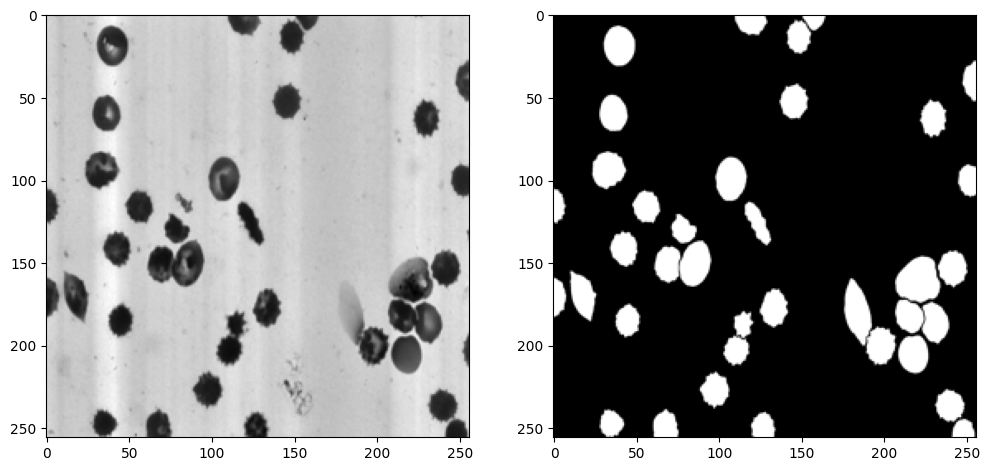

In [22]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()

# Creating and training the model

In [23]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

In [24]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
import keras.optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [50]:
def get_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    s = Lambda(lambda x: x/255) (inputs)

    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    """
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=10000,
        decay_rate=0.5,
        staircase=True)
    """
    opt = keras.optimizers.Adam(learning_rate=0.0001)

    #model.compile(optimizer='adam', loss='binary_crossentropy')
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    model.summary()

    return model

In [51]:
model = get_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 lambda_5 (Lambda)           (None, 256, 256, 1)          0         ['input_6[0][0]']             
                                                                                                  
 conv2d_95 (Conv2D)          (None, 256, 256, 16)         160       ['lambda_5[0][0]']            
                                                                                                  
 dropout_45 (Dropout)        (None, 256, 256, 16)         0         ['conv2d_95[0][0]']           
                                                                                            

In [52]:
"""
history = model.fit(X_train, y_train,
                    batch_size = 32,
                    verbose=1,
                    epochs=10,
                    validation_data=(X_test, y_test),
                    shuffle=False)

model.save('Image_segmentation_1.hdf5')
"""
filepath = "./Image_segmentation_1.hdf5"

earlystopper = EarlyStopping(patience=5, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [earlystopper, checkpoint]

history = model.fit(X_train, y_train, validation_split=0.2, batch_size=1, epochs=10, callbacks=callbacks_list)

Epoch 1/10
841/841 [==============================] - ETA: 0s - loss: 0.6211 - accuracy: 0.6572
Epoch 1: val_loss improved from inf to 0.59843, saving model to ./Image_segmentation_1.hdf5
841/841 [==============================] - 20s 17ms/step - loss: 0.6211 - accuracy: 0.6572 - val_loss: 0.5984 - val_accuracy: 0.6786
Epoch 2/10
838/841 [============================>.] - ETA: 0s - loss: 0.6095 - accuracy: 0.6577
Epoch 2: val_loss improved from 0.59843 to 0.59176, saving model to ./Image_segmentation_1.hdf5
841/841 [==============================] - 14s 17ms/step - loss: 0.6096 - accuracy: 0.6576 - val_loss: 0.5918 - val_accuracy: 0.6786
Epoch 3/10
839/841 [============================>.] - ETA: 0s - loss: 0.5066 - accuracy: 0.7064
Epoch 3: val_loss improved from 0.59176 to 0.23067, saving model to ./Image_segmentation_1.hdf5
841/841 [==============================] - 14s 16ms/step - loss: 0.5060 - accuracy: 0.7067 - val_loss: 0.2307 - val_accuracy: 0.8617
Epoch 4/10
839/841 [=========

# Evaluating results

In [53]:
# evaluate model
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

4/4 [==============================] - 1s 71ms/step - loss: 0.1124 - accuracy: 0.9026
Accuracy =  90.25679230690002 %


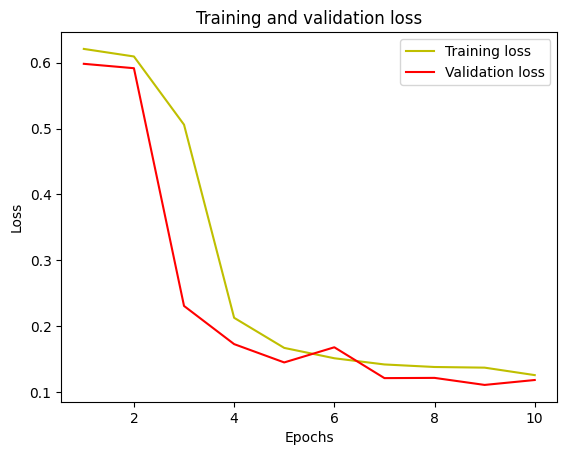

In [54]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

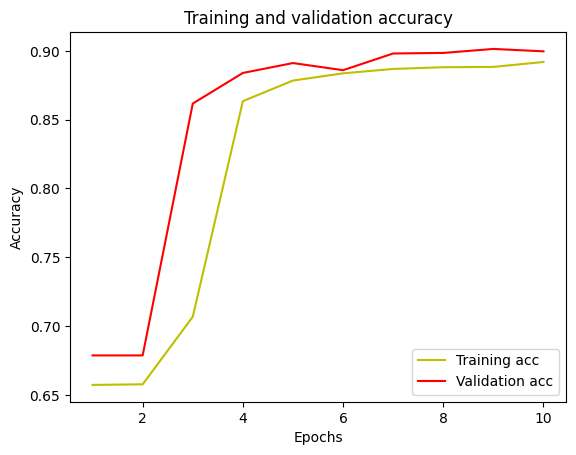

In [55]:
#acc = history.history['acc']
acc = history.history['accuracy']
#val_acc = history.history['val_acc']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [56]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

4/4 [==============================] - 1s 85ms/step
IoU socre is:  0.7822698516285266


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 282ms/step


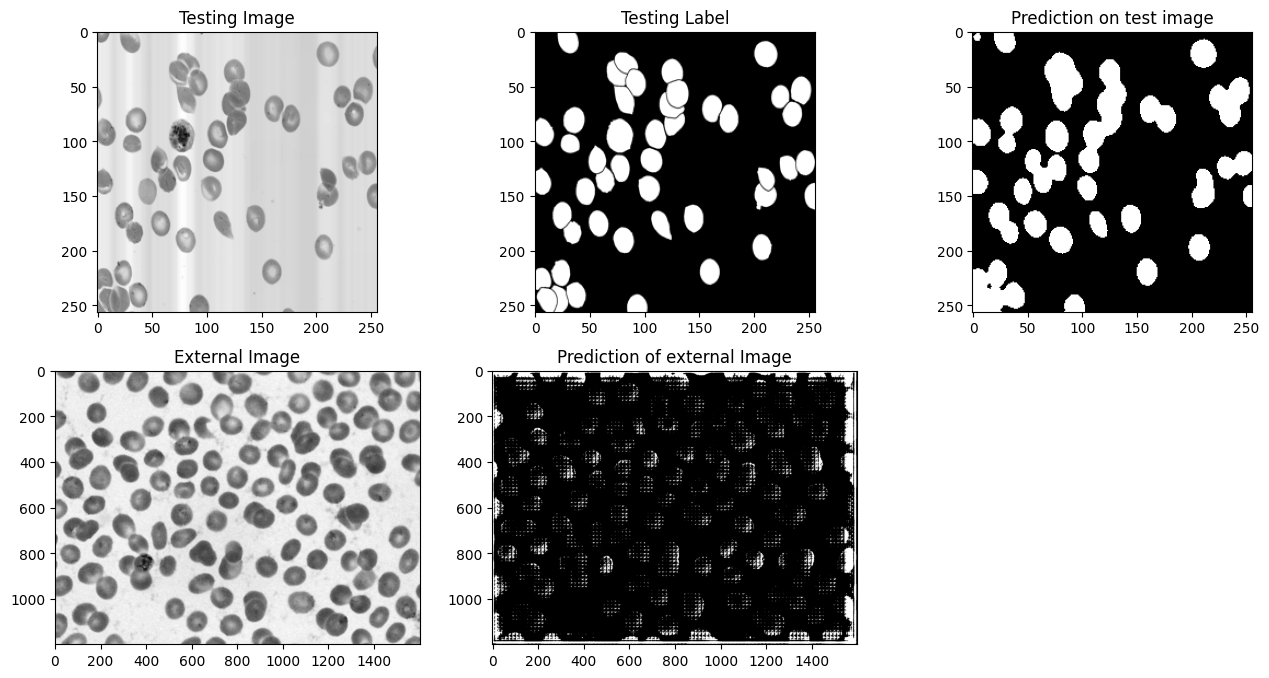

In [57]:
#Predict on a few images
model = keras.models.load_model('./Image_segmentation_1.hdf5')

test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.2).astype(np.uint8)

test_img_other = cv2.imread('/content/BCCD Dataset with mask/test/original/e16c0dab-780d-4035-872e-1bb91e49f9d2.png', 0)
#test_img_other = cv2.imread('data/test_images/img8.tif', 0)
test_img_other_norm = np.expand_dims(normalize(np.array(test_img_other), axis=1),2)
test_img_other_norm=test_img_other_norm[:,:,0][:,:,None]
test_img_other_input=np.expand_dims(test_img_other_norm, 0)

#Predict and threshold for values above 0.5 probability
#Change the probability threshold to low value (e.g. 0.05) for watershed demo.
prediction_other = (model.predict(test_img_other_input)[0,:,:,0] > 0.2).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')
plt.subplot(234)
plt.title('External Image')
plt.imshow(test_img_other, cmap='gray')
plt.subplot(235)
plt.title('Prediction of external Image')
plt.imshow(prediction_other, cmap='gray')
plt.show()

#plt.imsave('input.jpg', test_img[:,:,0], cmap='gray')
#plt.imsave('data/results/output2.jpg', prediction_other, cmap='gray')